In [1]:
import pandas as pd
import sklearn
import catboost as ctb

from sklearn import metrics
from matplotlib import pyplot as plt

# Постановка задачи

# Предобработка

Предобработка данных заключалась в следующих шагах:

* закодированы категориальные признаки
* отнормированы численные признаки
* удалены выбросы
* удалены пары признаков с большой корреляцией

Подробно посмотреть предварительный анализ можно $\href{https://github.com/katyalatypova/Methods-of-artificial-intelligence-in-data-analysis-2020/blob/master/notebooks/Preliminary%20analysis.ipynb}{здесь}$

# Исследованные модели

На данный момент были опробованы следующие методы:
* SVM c различными вариантами ядер - $\href{https://github.com/katyalatypova/Methods-of-artificial-intelligence-in-data-analysis-2020/blob/master/notebooks/SVM.ipynb}{ноутбук}$
* RandomForest - $\href{https://github.com/katyalatypova/Methods-of-artificial-intelligence-in-data-analysis-2020/blob/master/notebooks/RandomForest.ipynb}{ноутбук}$
* GradientBoosting (xgboost, catboost) - $\href{https://github.com/katyalatypova/Methods-of-artificial-intelligence-in-data-analysis-2020/blob/master/notebooks/Gradient%20Boosting.ipynb}{ноутбук}$


Для сравнения моделей между собой в этом ноутбуке были выбраны лучшие модели, полученные в каждом семействе моделей, исследованных в отдельных ноутбуках.

# Загрузка моделей

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('../data/processed/bank-additional-prepared.csv',
                   delimiter=';', index_col=0)

y = data['y_yes'].copy()
X = data.drop('y_yes', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42, stratify=y)

In [5]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', 
          class_weight='balanced',
          C=0.51,
          probability=True)

svm.fit(X_train, y_train)
y_pred_train_svm = svm.predict(X_train) 
y_pred_test_svm = svm.predict(X_test)

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(**{'max_depth': 21, 'min_samples_leaf': 1, 'n_estimators': 11})

clf.fit(X_train, y_train)
y_pred_train_clf = clf.predict(X_train) 
y_pred_test_clf = clf.predict(X_test)

In [7]:
ctb_classifier = ctb.CatBoostClassifier(eval_metric='F1',
                                        loss_function='Logloss',
                                        auto_class_weights='SqrtBalanced',
                                        depth=4,
                                        iterations=150,
                                        learning_rate=0.04,
                                        l2_leaf_reg=5.0,
                                        logging_level='Silent')

ctb_classifier.fit(X_train, y_train)
y_pred_train_ctb = ctb_classifier.predict(X_train) 
y_pred_test_ctb = ctb_classifier.predict(X_test)

# Результаты экспериментов

In [8]:
metrics_to_eval = {'Accuracy': lambda y_true, y_pred: metrics.accuracy_score(y_true, y_pred),
           'Balanced Accuracy': lambda y_true, y_pred: metrics.balanced_accuracy_score(y_true, y_pred),
            'AUC': lambda y_true, y_pred: metrics.roc_auc_score(y_true, y_pred),
           'Precision-0':  lambda y_true, y_pred: metrics.precision_score(y_true, y_pred, pos_label=0),
           'Precision-1':  lambda y_true, y_pred: metrics.precision_score(y_true, y_pred, pos_label=1), 
           'Recall-0':  lambda y_true, y_pred: metrics.recall_score(y_true, y_pred, pos_label=0), 
           'Recall-1':  lambda y_true, y_pred: metrics.recall_score(y_true, y_pred, pos_label=1),
           'F1-score-0':  lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, pos_label=0), 
           'F1-score-1':  lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, pos_label=1), 
           'F1-macro':  lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='macro')}

methods={'SVM': [(y_train, y_pred_train_svm), (y_test, y_pred_test_svm)],
         'GradientBoosting': [(y_train, y_pred_train_ctb), (y_test, y_pred_test_ctb)],
         'RandomForest': [(y_train, y_pred_train_clf), (y_test, y_pred_test_clf)]}

## Сравним модели на train

In [9]:
metrics_train = pd.DataFrame(columns=['SVM', 'RandomForest', 'GradientBoosting'],
                       index=['Accuracy', 
                              'Balanced Accuracy', 
                              'AUC', 
                              'Precision-0', 'Precision-1', 
                              'Recall-0', 'Recall-1',
                              'F1-score-0', 'F1-score-1', 'F1-macro'])

In [10]:
for metric, metric_func in metrics_to_eval.items():
    for method, predictions in methods.items():
        metrics_train.loc[metric, method] = metric_func(*predictions[0]).round(2)

In [11]:
metrics_train.head(len(metrics_to_eval) + 1)

,SVM,RandomForest,GradientBoosting
Accuracy,0.84,0.98,0.89
Balanced Accuracy,0.75,0.93,0.74
AUC,0.75,0.93,0.74
Precision-0,0.95,0.98,0.94
Precision-1,0.37,1,0.52
Recall-0,0.86,1,0.94
Recall-1,0.64,0.86,0.55
F1-score-0,0.91,0.99,0.94
F1-score-1,0.47,0.92,0.53
F1-macro,0.69,0.96,0.74


## Сравним модели на test

In [12]:
metrics_test = pd.DataFrame(columns=['SVM', 'RandomForest', 'GradientBoosting'],
                       index=['Accuracy', 
                              'Balanced Accuracy', 
                              'AUC', 
                              'Precision-0', 'Precision-1', 
                              'Recall-0', 'Recall-1',
                              'F1-score-0', 'F1-score-1', 'F1-macro'])

In [13]:
for metric, metric_func in metrics_to_eval.items():
    for method, predictions in methods.items():
        metrics_test.loc[metric, method] = metric_func(*predictions[1]).round(2)

In [14]:
metrics_test.head(len(metrics_to_eval) + 1)

,SVM,RandomForest,GradientBoosting
Accuracy,0.81,0.88,0.88
Balanced Accuracy,0.71,0.61,0.7
AUC,0.71,0.61,0.7
Precision-0,0.94,0.91,0.93
Precision-1,0.31,0.46,0.45
Recall-0,0.84,0.96,0.93
Recall-1,0.58,0.26,0.48
F1-score-0,0.89,0.94,0.93
F1-score-1,0.41,0.33,0.46
F1-macro,0.65,0.63,0.7


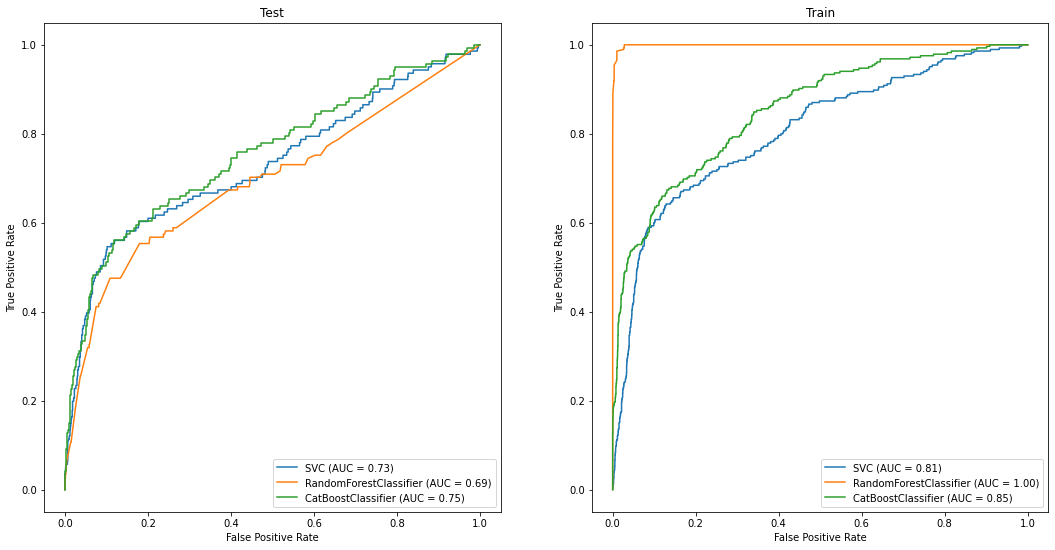

In [32]:
from sklearn.metrics import plot_roc_curve

plt.figure(figsize = (18,9))
ax1=plt.subplot(121)
ax2 = plt.subplot(122)
for model in [svm, clf, ctb_classifier]:   

    disp1 = plot_roc_curve(model,X_test, y_test, ax = ax1)
    disp1.ax_.set_title("Test")
    
    disp2 =plot_roc_curve(model,X_train, y_train, ax = ax2)
    disp2.ax_.set_title("Train")
plt.show()